<font size="6.2">Summary</font>  

LangGraph is an open-source framework by LangChain designed for constructing advanced multi-agent workflows powered by large language models (LLMs). This notebook begins by exploring Corrective Retrieval-Augmented Generation (RAG) and demonstrating use cases that highlight how self-grading or self-reflection can improve retrieval accuracy. It then covers techniques for enhancing questions to optimize document search. Finally, LangGraph is used to implement Corrective RAG, refine queries, and perform web searches to produce more reliable results.

Python functions and data files needed to run this notebook are available via this [link](https://github.com/MehdiRezvandehy/enhancing_retrieval_with_langGraph.git).

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
# pydantic libabray for defining the expected input and output
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# OpenAI key
os.environ['OPENAI_API_KEY'] = 'sk-........'

USER_AGENT environment variable not set, consider setting it to identify your requests.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Corrective-Retrieval-Augmented-Generation" data-toc-modified-id="Corrective-Retrieval-Augmented-Generation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Corrective Retrieval Augmented Generation</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Load-Documents" data-toc-modified-id="Load-Documents-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load Documents</a></span></li><li><span><a href="#Corrected-Retrieval" data-toc-modified-id="Corrected-Retrieval-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Corrected Retrieval</a></span></li></ul></li><li><span><a href="#Prebuilt-RAG-Prompt-Template" data-toc-modified-id="Prebuilt-RAG-Prompt-Template-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prebuilt RAG Prompt Template</a></span><ul class="toc-item"><li><span><a href="#Enhance-Questions-to-Optimize-Document-Search" data-toc-modified-id="Enhance-Questions-to-Optimize-Document-Search-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Enhance Questions to Optimize Document Search</a></span></li></ul></li><li><span><a href="#Using-LangGraph-to-Construct-the-Graph" data-toc-modified-id="Using-LangGraph-to-Construct-the-Graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using <a href="https://www.langchain.com/" rel="nofollow" target="_blank">LangGraph</a> to Construct the Graph</a></span><ul class="toc-item"><li><span><a href="#Function-for-Graph's-Nodes" data-toc-modified-id="Function-for-Graph's-Nodes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Function for Graph's Nodes</a></span></li><li><span><a href="#Functions-for-Graph's-Edges" data-toc-modified-id="Functions-for-Graph's-Edges-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Functions for Graph's Edges</a></span></li><li><span><a href="#Build-the-Graph" data-toc-modified-id="Build-the-Graph-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Build the Graph</a></span></li><li><span><a href="#Run-the-Graph" data-toc-modified-id="Run-the-Graph-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Run the Graph</a></span></li><li><span><a href="#Visualize-the-Graph" data-toc-modified-id="Visualize-the-Graph-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Visualize the Graph</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Corrective Retrieval Augmented Generation
## Introduction

**Corrective RAG (CRAG)** is an enhanced version of the standard Retrieval-Augmented Generation (RAG) framework that introduces *self-reflection* and *corrective behavior* into the retrieval and generation process.


🔍 **What is RAG?**

Traditional **RAG** systems:
1. **Retrieve** documents relevant to a query from a knowledge base.
2. **Augment** the query with those documents.
3. **Generate** an answer using a language model.

But: RAG assumes the retriever always returns useful content—which isn’t always true.

---

✅ What is **Corrective RAG (CRAG)**?

**CRAG** introduces a feedback loop where the system evaluates the quality of the retrieved documents *before* generating an answer.

**Key Concepts in CRAG:**
1. **Self-grading or Self-reflection**  
   After retrieval, each document is graded for *relevance* using a language model.

2. **Corrective Behavior**
   - If **some documents are relevant**, proceed with generation (possibly filtering out irrelevant ones).
   - If **no documents are relevant** or the model is **uncertain**, the system:
     - Supplements or replaces retrieval by using a **secondary data source** (e.g., a web search like Tavily).
     - Optionally rewrites the query to improve results.

## Load Documents

LangGaph and LangChain give resuable modules

In [2]:
# Define source URLs to load articles from
source_links = [
    "https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/",
    "https://medium.com/@codeplumber/region-proposal-network-rpn-backbone-of-faster-r-cnn-4a744a38d7f9/",
    "https://www.geeksforgeeks.org/what-is-ordinal-data/",
    "https://www.geeksforgeeks.org/introduction-convolution-neural-network/",
    "https://d2l.ai/chapter_computer-vision/"
]

# Load documents from the URLs
raw_documents = [WebBaseLoader(link).load() for link in source_links]
flattened_docs = [doc for group in raw_documents for doc in group]

# Initialize a text splitter for chunking the documents
chunker = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

chunked_documents = chunker.split_documents(flattened_docs)

# Create a vector store with embeddings
doc_vectorstore = Chroma.from_documents(
    documents=chunked_documents,
    collection_name="cnn-rpn-knowledge-base",
    embedding=OpenAIEmbeddings(),
)

# Create a retriever from the vector store
doc_retriever = doc_vectorstore.as_retriever()

In [3]:
query = "What is Intersection-Over-Union?"
results = doc_retriever.get_relevant_documents(query)

for result in results:
    print(result.page_content[:50], '...', result.metadata['source'])

C:\Users\mrezv\AppData\Local\Temp\ipykernel_25372\573328664.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = doc_retriever.get_relevant_documents(query)


Anchor boxes are boxes generated at image dimensio ... https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/
possible for each pixel, this is how the value of  ... https://medium.com/@codeplumber/region-proposal-network-rpn-backbone-of-faster-r-cnn-4a744a38d7f9/
OpenCV Selective Search For Object Detection       ... https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/
14.1. Image Augmentation
14.1.1. Common Image Augm ... https://d2l.ai/chapter_computer-vision/


## Corrected Retrieval
Assign a 'Relevant' or 'Not Relevant' label to each retrieved document depending on its relevance.

In [4]:
# Custom schema for grading document relevance
class RelevanceScore(BaseModel):
    """Binary relevance indicator for retrieved content."""

    relevance: str = Field(
        description="Indicates if the document answers the question: 'yes' or 'no'"
    )

# LLM setup with structured output schema
grader_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Bind LLM with the output schema
structured_grader = grader_model.with_structured_output(RelevanceScore)

# Prompt definition
grading_instruction = """Return 'Yes' or 'No' to indicate if the document is relevant to the given question."""
grading_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grading_instruction),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Composing the grader pipeline
document_grader = grading_prompt | structured_grader

# Iterate over retrieved documents and evaluate relevance
print(f'Question: {query}\n')
for result in results:
    content = result.page_content
    evaluation = document_grader.invoke({"document": content, "question": query})
    source = result.metadata['source']
    print(f'{evaluation}\ndocument: {content[:50]}\nsource: {source}')
    print('--------------------------------------------')

Question: What is Intersection-Over-Union?

relevance='Yes'
document: Anchor boxes are boxes generated at image dimensio
source: https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/
--------------------------------------------
relevance='No'
document: possible for each pixel, this is how the value of 
source: https://medium.com/@codeplumber/region-proposal-network-rpn-backbone-of-faster-r-cnn-4a744a38d7f9/
--------------------------------------------
relevance='No'
document: OpenCV Selective Search For Object Detection      
source: https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/
--------------------------------------------
relevance='Yes'
document: 14.1. Image Augmentation
14.1.1. Common Image Augm
source: https://d2l.ai/chapter_computer-vision/
--------------------------------------------


Only https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/ has relevance 'yes'

# Prebuilt RAG Prompt Template

In [5]:
from langchain import hub

# Load a prebuilt RAG prompt template from the LangChain hub
rag_prompt_template = hub.pull("rlm/rag-prompt")

# Display the type and content of each message in the prompt template
for msg in rag_prompt_template.messages:
    print(type(msg))
    print(msg.prompt.template)
    print('--------------------------------------------')

<class 'langchain_core.prompts.chat.HumanMessagePromptTemplate'>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
--------------------------------------------


In [6]:
from langchain_core.output_parsers import StrOutputParser

# Initialize the language model
chat_model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Helper function to format retrieved documents
def join_documents(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Construct the RAG pipeline
# Note: StrOutputParser() ensures clean string output from the LLM
rag_pipeline = rag_prompt_template | chat_model | StrOutputParser()

# Execute the chain with context and question
response = rag_pipeline.invoke({
    "context": join_documents(results),
    "question": query
})

print(response)

Intersection-Over-Union (IoU) is a metric used to evaluate the overlap between an anchor box and the object of interest. It is calculated as the ratio of the area of intersection between the two boxes to the area of their union. An IoU value greater than 0.7 typically indicates that the anchor box contains a foreground object.


## Enhance Questions to Optimize Document Search

In [7]:
# Using a different LLM model to demonstrate flexibility in multi-model usage
search_optimizer_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Prompt template for rewriting questions to be more effective for web search
system_instruction = """You are a query rewriter that improves an input question for optimal web search results. 
Analyze the question and identify its underlying semantic intent or meaning."""

query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_instruction),
        (
            "human",
            "Here is the original query: \n\n {question} \n Please rewrite it to be more effective.",
        ),
    ]
)

# Construct the pipeline: prompt -> LLM -> output parser
query_optimizer = query_rewrite_prompt | search_optimizer_llm | StrOutputParser()

# Execute with a sample question
print(f"Original question: {query}")
optimized_query = query_optimizer.invoke({"question": query})
print(f"Optimized question: {optimized_query}")


Original question: What is Intersection-Over-Union?
Optimized question: What is the definition and significance of Intersection-Over-Union (IoU) in the context of computer vision and object detection?


# Using [LangGraph](https://www.langchain.com/) to Construct the Graph

[LangGraph](https://www.langchain.com/) is an open-source framework developed by LangChain for building complex, multi-agent workflows using large language models (LLMs). Unlike traditional linear pipelines, LangGraph employs a graph-based architecture where agents—each handling specific tasks—are represented as nodes, and their interactions are defined by edges, allowing for dynamic, stateful, and iterative processes.

This design enables the creation of sophisticated AI systems where agents can collaborate, adapt based on feedback, and incorporate human-in-the-loop interactions, making it particularly effective for applications requiring modularity, scalability, and flexibility 

In [8]:
from typing import List
from typing_extensions import TypedDict

# Define a structured dictionary to track the workflow state of the graph process
class PipelineState(TypedDict):
    """
    A dictionary-style representation of the current state in the graph-based pipeline.

    Attributes:
        user_query (str): The original or reformulated question.
        llm_output (str): The response generated by the language model.
        retrieved_docs (List[str]): A collection of documents retrieved based on the query.
        rewrite_count (int): Number of times the query has been rephrased.
        enable_web_search (str): Placeholder indicating if a web search should be triggered
                                 (functionality not implemented in this version).
    """

    query: str
    llm_output: str
    retrieved_docs: List[str]
    rewrite_count: int
    enable_web_search: str


## Function for Graph's Nodes

This section defines a set of modular functions that operate on a shared query state to build a retrieval-augmented generation (RAG) pipeline. Each function is responsible for a specific step in the process and modifies or extends the shared QueryState dictionary.

The overall flow is structured to be stateful and composable, making it suitable for integration with graph-based execution frameworks like LangGraph.

In [9]:
from langchain.schema import Document

def initialize_state(query_state):
    """
    Initializes values in the query state.

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: State dictionary with initialized rewrite_count.
    """
    print("---INITIALIZE QUERY STATE---")
    return {"rewrite_count": 0}


def fetch_documents(query_state):
    """
    Retrieves relevant documents for the given query.

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: An updated state dictionary with a new key 'retrieved_docs'.
    """
    print(query_state)
    print("---FETCH DOCUMENTS---")

    query = query_state["query"]

    # Perform document retrieval
    relevant_docs = doc_retriever.get_relevant_documents(query)
    return {"retrieved_docs": relevant_docs}


def filter_relevant_documents(query_state):
    """
    Evaluates and filters retrieved documents for relevance to the query.

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: Updated state with only relevant documents and web search indicator.
    """
    print("---EVALUATE DOCUMENT RELEVANCE---")
    query = query_state["query"]
    documents = query_state["retrieved_docs"]

    filtered_results = []
    should_perform_web_search = "No"

    for doc in documents:
        score = document_grader.invoke({
            "question": query,
            "document": doc.page_content
        })
        is_relevant = score.relevance
        print(doc.metadata.get('source', 'Unknown'), f'Score: {is_relevant}')

        if is_relevant == "Yes":
            print("---DOCUMENT IS RELEVANT---")
            filtered_results.append(doc)

    if not filtered_results:
        print("---NO RELEVANT DOCUMENTS FOUND---")
        should_perform_web_search = "Yes"

    return {
        "retrieved_docs": filtered_results,
        "perform_web_search": should_perform_web_search
    }


def refine_query(query_state):
    """
    Rewrites the input query to improve clarity and search effectiveness.

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: Updated state with a refined query and incremented transformation count.
    """
    print("---REFINE QUERY---")

    query = query_state["query"]
    rewrite_count = query_state["rewrite_count"] + 1

    # Rewrite the query using a question rewriter
    improved_query = query_optimizer.invoke({"question": query})

    print("---IMPROVED QUERY---")
    print(improved_query)

    return {
        "query": improved_query,
        "rewrite_count": rewrite_count}


def generate_response(query_state):
    """
    Generates a response using RAG (Retrieval-Augmented Generation).

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: An updated state dictionary with a new key 'llm_output'.
    """
    print("---GENERATE RESPONSE---")

    query = query_state["query"]
    documents = query_state["retrieved_docs"]

    # Generate an answer using RAG
    response = rag_pipeline.invoke({
        "context": join_documents(documents),
        "question": query
    })

    return {"llm_output": response}


## Functions for Graph's Edges

You can get your API key from https://app.tavily.com

In [10]:
os.environ["TAVILY_API_KEY"] = "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"

In [11]:
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain.schema.document import Document

def web_search(query_state):
    """
    Executes a web search using the given query and returns a list of document objects.

    Args:
        query_state: The current query state containing the search question.

    Returns:
        Dict[str, Any]: Updated state including the original question and retrieved documents.
    """
    query = query_state["query"]

    search_client = TavilySearchAPIWrapper()
    search_results = search_client.results(query=query, max_results=3)

    retrieved_docs = [
        Document(page_content=item["content"], metadata={"source": item["url"]})
        for item in search_results
    ]

    return {
        "query": query,
        "retrieved_docs": retrieved_docs
    }


def decide_next_action(query_state):
    """
    Determines the next step in the workflow: whether to generate an answer
    or rephrase the query again for better document retrieval.

    Args:
        query_state (dict): The current state of the query process.

    Returns:
        str: The next action to take - either 'if_generate' or 'if_transform_query'.
    """

    print("---ASSESSING DOCUMENT RELEVANCE---")
    requires_web_search = query_state["perform_web_search"]

    if requires_web_search == "Yes":
        # If the query has already been transformed multiple times with no success,
        # proceed to generate an answer anyway.
        if query_state["rewrite_count"] >= 3:
            print(
                "---DECISION: MAX REWRITES REACHED AND NO RELEVANT DOCUMENTS FOUND → LETS APPLY WEB SEARCH---"
            )        
            
            return "apply_web_search"

        # Still below the rewrite threshold; attempt another reformulation.
        print(
            "---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---"
        )
        return "apply_transform_query"

    else:
        # Relevant documents are present; move on to answer generation.
        print("---DECISION: RELEVANT DOCUMENTS FOUND → GENERATE---")
        return "apply_generate"


## Build the Graph

In [12]:
from langgraph.graph import START, END, StateGraph

# Create a new stateful graph using the defined PipelineState structure
pipeline_graph = StateGraph(PipelineState)

# Register processing steps (nodes) in the graph
pipeline_graph.add_node("initialize_state", initialize_state)                   # Step 1: Initialize state
pipeline_graph.add_node("fetch_documents", fetch_documents)                     # Step 2: Retrieve documents
pipeline_graph.add_node("filter_relevant_documents", filter_relevant_documents) # Step 3: Grade relevance
pipeline_graph.add_node("generate_response", generate_response)                 # Step 4: Generate answer
pipeline_graph.add_node("refine_query", refine_query)                           # Step 5: Refine query if needed
pipeline_graph.add_node("web_search", web_search)                               # Step 6: Web search

# Define the workflow logic by adding edges between steps (nodes)
pipeline_graph.add_edge(START, "initialize_state")
pipeline_graph.add_edge("initialize_state", "fetch_documents")
pipeline_graph.add_edge("fetch_documents", "filter_relevant_documents")

# Add branching logic after grading based on decision function
pipeline_graph.add_conditional_edges(
    "filter_relevant_documents",
    decide_next_action,
    {
        "apply_transform_query": "refine_query",
        "apply_web_search": "web_search",
        "apply_generate": "generate_response",
    }
)

# Handle loopback and termination
pipeline_graph.add_edge("refine_query", "fetch_documents")
pipeline_graph.add_edge("web_search", "generate_response")
pipeline_graph.add_edge("generate_response", END)

# Finalize and compile the pipeline
retrieval_qa_pipeline = pipeline_graph.compile()

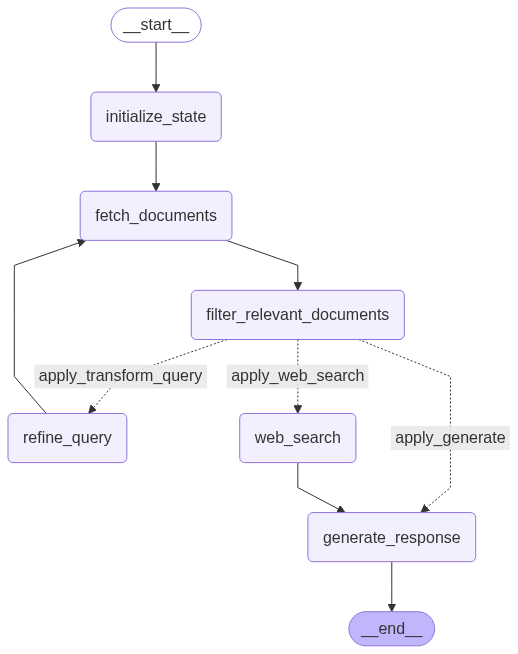

In [13]:
retrieval_qa_pipeline

## Run the Graph

* **Query 1**

In [14]:
inputs = {"query": "What is feature map?"}
for output in retrieval_qa_pipeline.stream(inputs):
    for key, value in output.items():
        # Node
        print("\n")
        print(f"Node '{key}':")
# Final generation
print(value["llm_output"])

---INITIALIZE QUERY STATE---


Node 'initialize_state':
{'query': 'What is feature map?', 'rewrite_count': 0}
---FETCH DOCUMENTS---


Node 'fetch_documents':
---EVALUATE DOCUMENT RELEVANCE---
https://www.geeksforgeeks.org/introduction-convolution-neural-network/ Score: Yes
---DOCUMENT IS RELEVANT---
https://medium.com/@codeplumber/region-proposal-network-rpn-backbone-of-faster-r-cnn-4a744a38d7f9/ Score: Yes
---DOCUMENT IS RELEVANT---
https://www.geeksforgeeks.org/introduction-convolution-neural-network/ Score: No
https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/ Score: No
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: RELEVANT DOCUMENTS FOUND → GENERATE---


Node 'filter_relevant_documents':
---GENERATE RESPONSE---


Node 'generate_response':
A feature map is the output generated by applying a convolutional filter to an input image patch, resulting in a representation of specific features detected in the image. In a convolutional layer, multiple filters pr

* **Query 2**

In [15]:
inputs = {"query": "What is Intersection-Over-Union?"}
for output in retrieval_qa_pipeline.stream(inputs):
    for key, value in output.items():
        # Node
        print("\n")
        print(f"Node '{key}':")
# Final generation
print(value["llm_output"])

---INITIALIZE QUERY STATE---


Node 'initialize_state':
{'query': 'What is Intersection-Over-Union?', 'rewrite_count': 0}
---FETCH DOCUMENTS---


Node 'fetch_documents':
---EVALUATE DOCUMENT RELEVANCE---
https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/ Score: Yes
---DOCUMENT IS RELEVANT---
https://medium.com/@codeplumber/region-proposal-network-rpn-backbone-of-faster-r-cnn-4a744a38d7f9/ Score: No
https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/ Score: No
https://d2l.ai/chapter_computer-vision/ Score: Yes
---DOCUMENT IS RELEVANT---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: RELEVANT DOCUMENTS FOUND → GENERATE---


Node 'filter_relevant_documents':
---GENERATE RESPONSE---


Node 'generate_response':
Intersection-Over-Union (IoU) is a metric used to evaluate the overlap between an anchor box and the object of interest. It is calculated as the ratio of the area of intersection to the area of the union of the two boxes. An IoU

* **Query 3**

In [16]:
inputs = {"query": "What is Ordinal Chi-Square Test?"}
for output in retrieval_qa_pipeline.stream(inputs):
    for key, value in output.items():
        # Node
        print("\n")
        print(f"Node '{key}':")
# Final generation
print(value["llm_output"])

---INITIALIZE QUERY STATE---


Node 'initialize_state':
{'query': 'What is Ordinal Chi-Square Test?', 'rewrite_count': 0}
---FETCH DOCUMENTS---


Node 'fetch_documents':
---EVALUATE DOCUMENT RELEVANCE---
https://www.geeksforgeeks.org/what-is-ordinal-data/ Score: Yes
---DOCUMENT IS RELEVANT---
https://www.geeksforgeeks.org/what-is-ordinal-data/ Score: Yes
---DOCUMENT IS RELEVANT---
https://www.geeksforgeeks.org/what-is-ordinal-data/ Score: No
https://www.geeksforgeeks.org/what-is-ordinal-data/ Score: No
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: RELEVANT DOCUMENTS FOUND → GENERATE---


Node 'filter_relevant_documents':
---GENERATE RESPONSE---


Node 'generate_response':
The Ordinal Chi-Square Test is a statistical method used to determine if there is a significant association between two or more ordinal variables. It evaluates the relationship by comparing the observed frequencies of the categories in a contingency table. This test is particularly useful when dealing with data that

* **Query 4**

In [17]:
inputs = {"query": "What is the deepest lake on the world?"}
for output in retrieval_qa_pipeline.stream(inputs):
    for key, value in output.items():
        # Node
        print("\n")
        print(f"Node '{key}':")
# Final generation
print(value["llm_output"])

---INITIALIZE QUERY STATE---


Node 'initialize_state':
{'query': 'What is the deepest lake on the world?', 'rewrite_count': 0}
---FETCH DOCUMENTS---


Node 'fetch_documents':
---EVALUATE DOCUMENT RELEVANCE---
https://d2l.ai/chapter_computer-vision/ Score: No
https://www.geeksforgeeks.org/introduction-convolution-neural-network/ Score: No
https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/ Score: No
https://www.geeksforgeeks.org/introduction-convolution-neural-network/ Score: No
---NO RELEVANT DOCUMENTS FOUND---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---


Node 'filter_relevant_documents':
---REFINE QUERY---
---IMPROVED QUERY---
What is the deepest lake in the world?


Node 'refine_query':
{'query': 'What is the deepest lake in the world?', 'retrieved_docs': [], 'rewrite_count': 1}
---FETCH DOCUMENTS---


Node 'fetch_documents':
---EVALUATE DOCUMENT RELEVANCE---
https://d2l.ai/chapter_computer-vi

In [18]:
inputs = {"query": "Who is Donal Trump?"}
for output in retrieval_qa_pipeline.stream(inputs):
    for key, value in output.items():
        # Node
        print("\n")
        print(f"Node '{key}':")
# Final generation
print(value["llm_output"])

---INITIALIZE QUERY STATE---


Node 'initialize_state':
{'query': 'Who is Donal Trump?', 'rewrite_count': 0}
---FETCH DOCUMENTS---


Node 'fetch_documents':
---EVALUATE DOCUMENT RELEVANCE---
https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/ Score: No
https://www.geeksforgeeks.org/introduction-convolution-neural-network/ Score: No
https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/ Score: No
https://www.geeksforgeeks.org/introduction-convolution-neural-network/ Score: No
---NO RELEVANT DOCUMENTS FOUND---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---


Node 'filter_relevant_documents':
---REFINE QUERY---
---IMPROVED QUERY---
Rewritten query: 

Who is Donald Trump and what is his background in politics and business?


Node 'refine_query':
{'query': 'Rewritten query: \n\nWho is Donald Trump and what is his background in politics and business?', 'retrieved_docs': [], 'rewrite

## Visualize the Graph

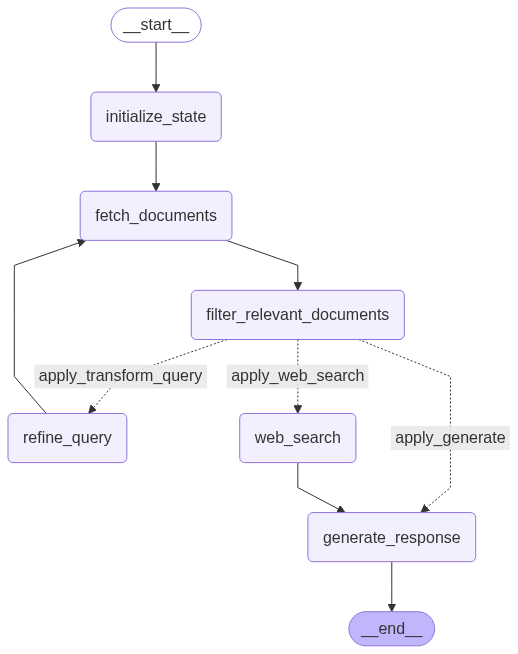

In [19]:
# Visualize our graph
from IPython.display import Image, display
try:
    display(Image(retrieval_qa_pipeline.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [20]:
# if the above fails try this (requires grandalf)
print(retrieval_qa_pipeline.get_graph().draw_ascii())

                                +-----------+                               
                                | __start__ |                               
                                +-----------+                               
                                      *                                     
                                      *                                     
                                      *                                     
                            +------------------+                            
                            | initialize_state |                            
                            +------------------+                            
                                      *                                     
                                      *                                     
                                      *                                     
                             +-----------------+                            

# Summary

From the code above, we can see that unlike Crew.ai, LangGraph allows us to explicitly define the behavior of our agent graph. However, this comes at the cost of ease of use—there's a significant amount of boilerplate just to create a single agent, and that's not even for a multi-agent setup. Much of the code involves manually specifying each step the agent should take. On the other hand, many people expect agents to figure things out on their own without needing such detailed instructions. So, between Crew and LangGraph, we’re already seeing a split in the agent ecosystem: LangGraph takes a more hardcoded, deterministic approach where the developer dictates the entire flow, while Crew leans into the idea of smart LLMs—just give them a task and the tools, and let them decide how to proceed.